# 1. Load and process dataframe

In [ ]:
!mkdir vo2_max_data
!cp LoganHennessy/user-site-export/demographic_vo2_max* vo2_max_data/

As in the previous analysis, we can load the data using a simple for-loop and Pandas `concat()` function.

In [2]:
import os
import pandas as pd

dfs = []
for file in os.listdir("vo2_max_data"):
    dfs.append(pd.read_json(f"vo2_max_data/{file}"))
df = pd.concat(dfs)

Once again, our interesting data has been loaded as a JSON object, making it difficult to access the fields we want.

Start by taking a look at the first value to understand how the JSON object is structured. The data we're interested has been stored in a generically-named `value` column.

In [3]:
df.iloc[0].value

{'demographicVO2Max': 47.60661,
 'demographicVO2MaxError': 3.0,
 'filteredDemographicVO2Max': 47.08661000000001,
 'filteredDemographicVO2MaxError': 0.36310000000000003}

Only four fields, let's parse them into their own columns.

In [4]:
df["demographicVO2Max"] = df.value.apply(lambda val: val["demographicVO2Max"])
df["demographicVO2MaxError"] = df.value.apply(lambda val: val["demographicVO2MaxError"])
df["filteredDemographicVO2Max"] = df.value.apply(lambda val: val["filteredDemographicVO2Max"])
df["filteredDemographicVO2MaxError"] = df.value.apply(lambda val: val["filteredDemographicVO2MaxError"])

And drop the now-useless `value` column.

In [5]:
df.drop(columns=["value"], inplace=True)

Standard date-index manipulation.

In [6]:
df.dateTime = pd.to_datetime(df.dateTime)
df.set_index("dateTime", drop=True, inplace=True)
df.sort_index(inplace=True)

Cool. Now, let's get take a look at how our dataframe is shaping up.

In [7]:
df.head()

,demographicVO2Max,demographicVO2MaxError,filteredDemographicVO2Max,filteredDemographicVO2MaxError
dateTime,,,,
2017-04-01,46.12836,3.0,46.12836,3.00000
2017-04-02,47.33182,3.0,46.73506,1.51239
2017-04-03,47.31893,3.0,46.93501,1.02735
2017-04-04,46.52296,3.0,46.82613,0.79268
2017-04-05,46.31675,3.0,46.71443,0.65788


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835 entries, 2017-04-01 to 2019-09-28
Data columns (total 4 columns):
demographicVO2Max                 835 non-null float64
demographicVO2MaxError            835 non-null float64
filteredDemographicVO2Max         835 non-null float64
filteredDemographicVO2MaxError    835 non-null float64
dtypes: float64(4)
memory usage: 32.6 KB


Looking good. We've got a Datetime Index with our data sorted from oldest to newest, and all of our interesting data is in it's own dedicated column. Now it's time to visualize.

# 2. Plotting and visualization

One of the simplest ways to plot is to just pass in the entire dataframe to Seaborn's `lineplot` method.

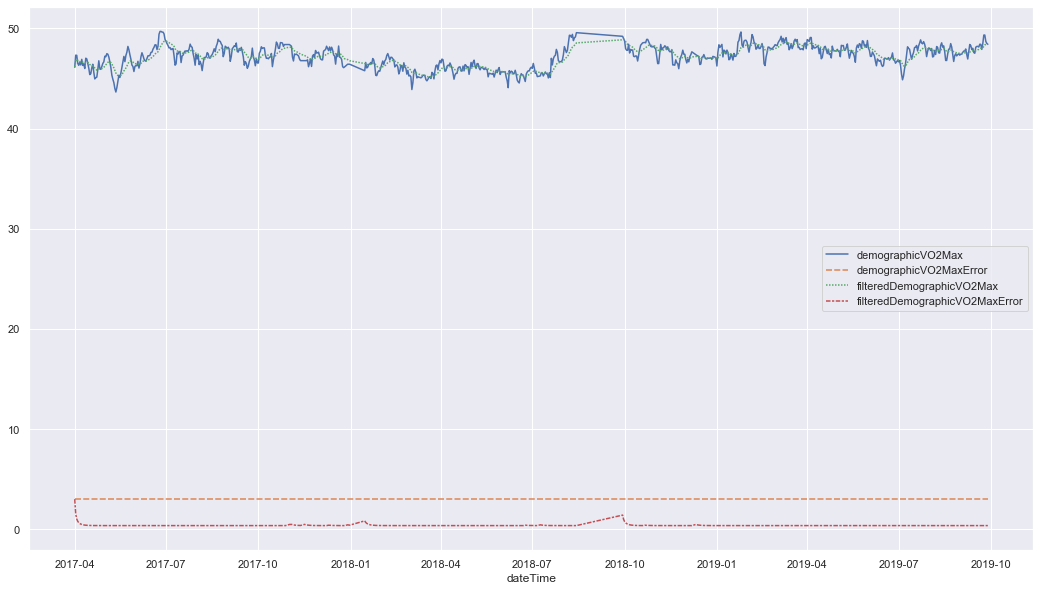

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set()

fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(ax=ax, data=df)

This is great for getting a quick snapshot of our data on a graph. We can see that the `demographicVO2Max` and `filteredDemographicVO2Max` both hover in the 45-50 range, and the `demographicVO2MaxError` and `filteredDemographicVO2MaxError` columns are more-or-less constant values less than 5.

But this isn't incredibly useful is we actually want to do something with our data like, say, trend it.

To do that, we need to zoom in a bit and get a better understanding of how these values change over time.

Since the error columns are basically constants, and I'm not sure what is meant by the "filtered" value, let's zoom in on the `demographicVO2Max` data and see what we find.

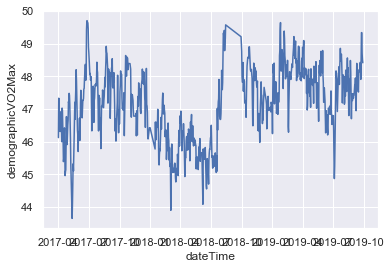

In [10]:
sns.lineplot(df.index, df.demographicVO2Max)

Okay, that's looking a little more interesting. At this level we're able to get a sense of how the data changes over the ~2.5 year period.

We used a `lineplot` to graph this chart, but that isn't actually very much, in fact, it's sort of hiding the underlying data behind a lot of blue "ink" - if you will.

Seaborn's `scatterplot` removes these lines.

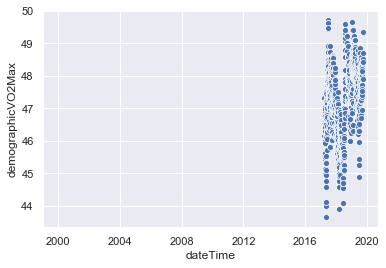

In [11]:
sns.scatterplot(df.index, df.demographicVO2Max)

Whoa. What's going on there? Why is all our data squished up on the right of the graph?

The trick here has to do with matplotlib's `scatter` method. Under the hood, Seaborn calls this method to plot data passed to `scatterplot`. That method does not handle dates well by default. You can read more about this [here](https://github.com/mwaskom/seaborn/issues/1641).

Bottom-line, we need to drop down from Seaborn to matplotlib's `plot_date` method to handle this appropriately.

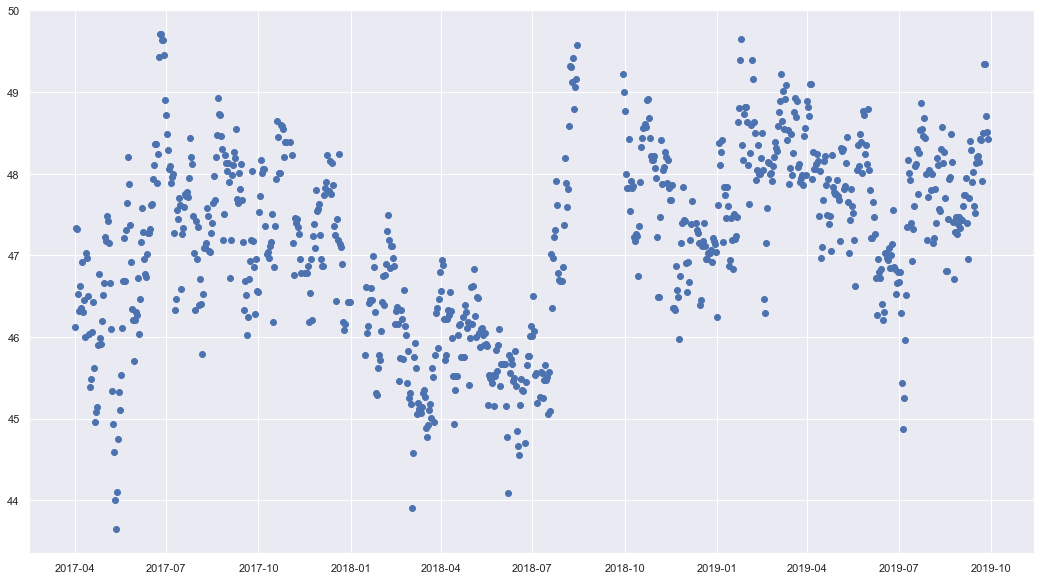

In [12]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot_date(df.index, df.demographicVO2Max)

That's looking much better. Now we can realize see what this data is telling us. Note how the data oscillates over the plotted time-range, this is something we'll look at much more closely later.

# 3. Trending

Trending is a **huge** topic. I only have so much time, and so much of your attention, so I intend to hone in on two methods of trending.
1. Linear Regression
2. Moving averages

## 3.1 Linear Regression

In [22]:
import numpy as np
from sklearn import linear_model
X = np.array(list(range(len(df.index.values)))).reshape(-1,1)
y = df.demographicVO2Max.values.reshape(-1,1)
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = df.index.values.reshape(-1,1)
y = df.demographicVO2Max.values.reshape(-1,1)
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

$$y=mx+b$$

Where $m$ is the slope, and $b$ is the $y$-intercept.

In [14]:
print(reg.coef_)
print(reg.intercept_)

[[1.46757656e-17]]
[24.70266799]


In [ ]:
dfs = []
for file in os.listdir("vo2_max_data"):
    dfs.append(pd.read_json(f"vo2_max_data/{file}"))
df = pd.concat(dfs)
df["demographicVO2Max"] = df.value.apply(lambda val: val["demographicVO2Max"])
df["demographicVO2MaxError"] = df.value.apply(lambda val: val["demographicVO2MaxError"])
df["filteredDemographicVO2Max"] = df.value.apply(lambda val: val["filteredDemographicVO2Max"])
df["filteredDemographicVO2MaxError"] = df.value.apply(lambda val: val["filteredDemographicVO2MaxError"])
df.drop(columns=["value"], inplace=True)

In [21]:
df["dateOrdinal"] = pd.to_datetime(df['dateTime']).apply(lambda date: date.toordinal())

AttributeError: 'DatetimeIndex' object has no attribute 'toordinal'

In [14]:
df.head()

,demographicVO2Max,demographicVO2MaxError,filteredDemographicVO2Max,filteredDemographicVO2MaxError
dateTime,,,,
2017-04-01,46.12836,3.0,46.12836,3.00000
2017-04-02,47.33182,3.0,46.73506,1.51239
2017-04-03,47.31893,3.0,46.93501,1.02735
2017-04-04,46.52296,3.0,46.82613,0.79268
2017-04-05,46.31675,3.0,46.71443,0.65788


AttributeError: 'DatetimeIndex' object has no attribute 'mean'

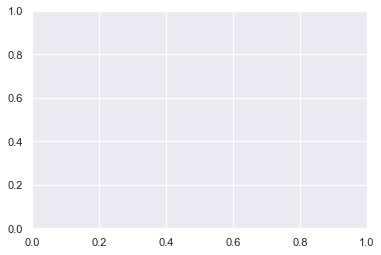

In [22]:
sns.regplot(data=df, x=df.index, y="demographicVO2Max")

... skipping a few steps to get some of the line fit stuff copied over ... I haven't really looked at this closely to make sure it all makes great sense... but it works so...

In [15]:
X = df.index.values.reshape(-1,1)
y = df.demographicVO2Max.values.reshape(-1,1)

In [16]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
print(f"Coef: {reg.coef_}")
print(f"Intercept: {reg.intercept_}")

Coef: [[1.46757656e-17]]
Intercept: [24.70266799]


## Here is the trick!

Basically, the problem if you just try to plot the data using timestamps (which get converted to UNIX Epoch, which is the number of seconds since Jan 1st 1970) you get really funky numbers and a line that is basically flat in the window that we care about.

And actually, Pandas uses microseconds since epoch, which is weird but you get numbers like this: `1491004800000000000` when you look at the "value" property of a pandas timestamp.

To get past this, we have to convert these to regular numbers from 1 to n where n is the length of our data.

...I might be leaving something out here, I need to sit down and think about it more, but I might have to actually skip numbers in this list like I do when I convert BACK to timestamps. 

In [18]:
import numpy as np
X = np.array(list(range(len(df.index.values)))).reshape(-1,1)
#X = np.array(X)

In [19]:
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
slope = reg.coef_
slope

array([[0.00139158]])

In [24]:
intercept = reg.intercept_
intercept

array([46.58244957])

In [25]:
x_vals = np.array(ax.get_xlim())
x_vals = x_vals - ax.get_xlim()[0]
x_vals

array([   0., 1001.])

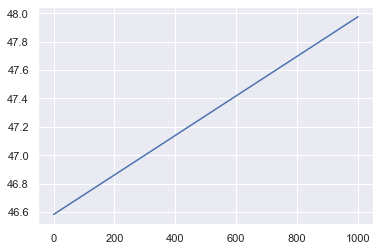

In [26]:
y_vals = intercept[0] + slope[0][0] * x_vals
plt.plot(x_vals, y_vals)

In [27]:
prev = df.index[0]
X = [0]
i = 1
for curr in df.index[1:]:
    while (curr - prev).days > 1:
        prev += pd.Timedelta(days=1)
        i += 1
    X.append(i)

In [28]:
X_ts = [pd.Timestamp(1491004800000000000 + (x * int(8.64e+13))) for x in X]

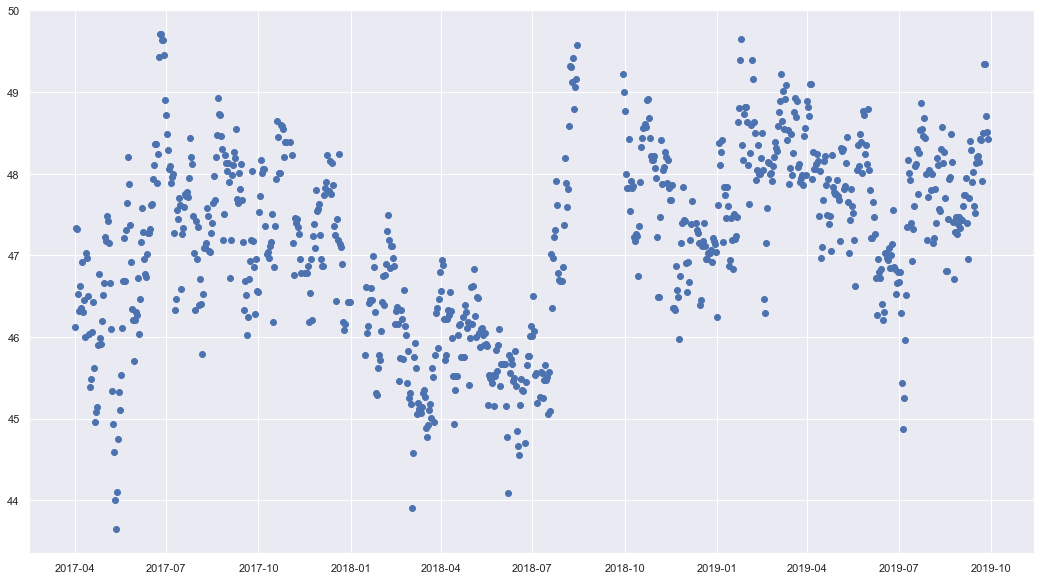

In [29]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot_date(df.index, df.demographicVO2Max)

In [30]:
X_vals = np.array(X_ts)
y_vals = reg.intercept_[0] + reg.coef_[0][0] * np.array(X)

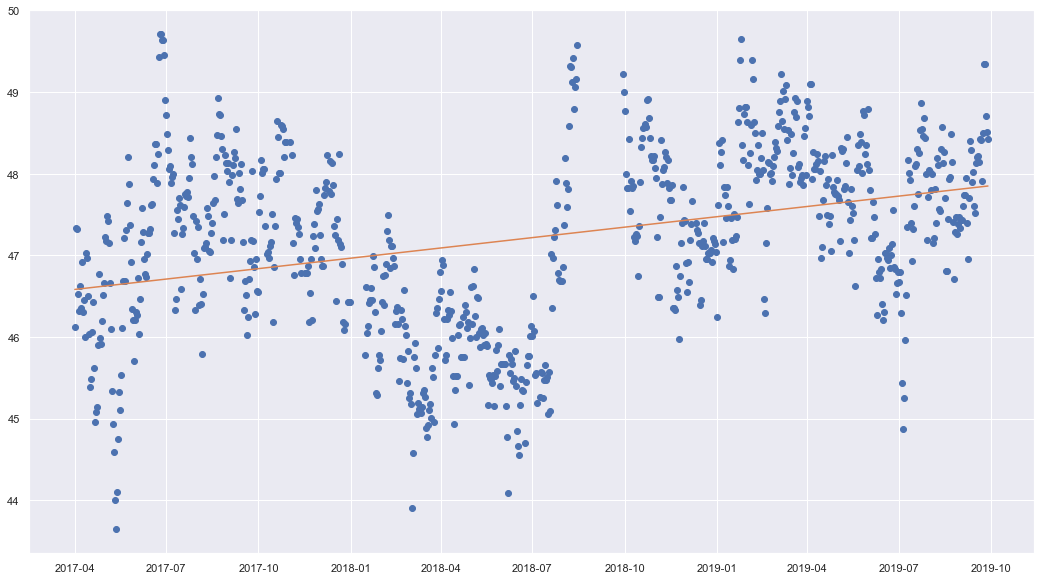

In [31]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot_date(df.index, df.demographicVO2Max)
ax.plot(X_vals, y_vals)